# Khmer Text Summarization - Extractive Methods

1. Load The Dataset

In [60]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/drive')

# Load data
data = pd.read_csv("/Summarization.csv")
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,text,summary
0,0,លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយ...,Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២...
1,1,លោក Luis Enrique គ្រូបង្វឹក Paris Saint Germai...,លោក Luis Enrique បដិសេធពាក្យចចាមអារ៉ាមថា ចង់ចា...
2,2,អង់គ្លេស៖ ក្រុមមាន់ខ្នាយមាស Tottenham Hotspur ...,Tottenham Hotspur នឹងប្រឹងប្រយុទ្ធប្រកួតជាមួយ ...
3,3,សហព័ន្ធបាល់ទាត់អឺរ៉ុប UEFA នឹងធ្វើសេចក្ដីសម្រេ...,UEFA នឹងសម្រេចក្នុងខែមិថុនាថា Barcelona ត្រូវដ...
4,4,ថ្មីៗនេះ មានរបាយការណ៍មកថា តារាឆ្នើមក្រុម Arsen...,Bukayo Saka កីឡាកររបស់ Arsenal កំពុងទាក់ទាញចំណ...


In [61]:
# Drop the unname column
df = data.drop('Unnamed: 0', axis=1)
df.head()

,text,summary
0,លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយ...,Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២...
1,លោក Luis Enrique គ្រូបង្វឹក Paris Saint Germai...,លោក Luis Enrique បដិសេធពាក្យចចាមអារ៉ាមថា ចង់ចា...
2,អង់គ្លេស៖ ក្រុមមាន់ខ្នាយមាស Tottenham Hotspur ...,Tottenham Hotspur នឹងប្រឹងប្រយុទ្ធប្រកួតជាមួយ ...
3,សហព័ន្ធបាល់ទាត់អឺរ៉ុប UEFA នឹងធ្វើសេចក្ដីសម្រេ...,UEFA នឹងសម្រេចក្នុងខែមិថុនាថា Barcelona ត្រូវដ...
4,ថ្មីៗនេះ មានរបាយការណ៍មកថា តារាឆ្នើមក្រុម Arsen...,Bukayo Saka កីឡាកររបស់ Arsenal កំពុងទាក់ទាញចំណ...


In [62]:
!pip install khmer-nltk

In [63]:
!pip install rouge-score

In [64]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
from khmernltk import word_tokenize

2. Stopwords

In [65]:
KHMER_STOPWORDS = {
    'និង','ដែល','ជា','នៅ','ទៅ','ពី','នេះ','នោះ','បាន','មាន',
    'ក៏','ឬ','ទេ','ហើយ','ទាំង','ទាំងអស់','ប៉ុន្តែ','ដោយ',
    'ព្រោះ','ដើម្បី','ថា','អោយ','ឲ្យ','គឺ','អាច','ត្រូវ',
    'មិន','មែន','តែ','បើ','ពេល','ខណៈ','ក្នុង','លើ','ក្រោម',
    'ជាមួយ','ចំពោះ','រួម','តាម','មក','ទៅ','វិញ'
}

3. Sentence Split

In [66]:
def khmer_sentence_split(text):
    sentences = re.split(r'[។?!]', text)
    return [s.strip() for s in sentences if len(s.strip()) > 5]

4. Normalize and Clean

In [67]:
def tokenize_and_clean(text):
    text = text.lower()
    text = re.sub(r'[^\u1780-\u17FFa-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence)
    tokens = [t for t in tokens if t not in KHMER_STOPWORDS]
    return " ".join(tokens)

5. Preprocess Text

In [68]:
def preprocess_text(text):
    raw_sentences = khmer_sentence_split(text)
    clean_sentences = []
    tokenized_sentences = []

    for s in raw_sentences:
        s_norm = tokenize_and_clean(s)
        tokens = word_tokenize(s_norm)
        tokens = [t for t in tokens if t not in KHMER_STOPWORDS]

        clean_sentences.append(" ".join(tokens))
        tokenized_sentences.append(tokens)

    return raw_sentences, clean_sentences, tokenized_sentences

## Model 1: TF-IDF Summarizer

In [69]:
def tfidf_summarize(text, summary_ratio=0.3):
    raw_sentences, clean_sentences, _ = preprocess_text(text)

    # TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.9)
    tfidf_matrix = vectorizer.fit_transform(clean_sentences)

    # Sentence scores
    sentence_scores = tfidf_matrix.sum(axis=1).A1

    # Select top sentences
    n_sentences = max(1, int(len(raw_sentences) * summary_ratio))
    top_indices = np.argsort(sentence_scores)[-n_sentences:]
    top_indices = sorted(top_indices)

    summary = "។ ".join([raw_sentences[i] for i in top_indices]) + "។"

    return summary, sentence_scores, raw_sentences

1. ROUGE Evaluation

In [70]:
def evaluate_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=False)
    return scorer.score(reference, prediction)

2. First Article Example

In [71]:
text = data.loc[0, "text"]
gold_summary = data.loc[0, "summary"]

pred_summary, scores, sentences = tfidf_summarize(text)

print("Predicted Summary:\n", pred_summary)
print("\nReference Summary:\n", gold_summary)

Predicted Summary:
 ជាការពិត Man City បានធានាជើងឯក Premier League បន្ទាប់ពីក្រុម Arsenal ដែលប្រដេញតំណែងជើងឯកយ៉ាងប្រកៀកប្រកិតរហូតមកនោះ បានប្រកួតចាញ់ក្រុម Nottingham Forest។ ដូច្នេះហើយ បន្ទាប់ពីការប្រកួតឈ្នះ ក្រុម Chelsea ដោយលទ្ធផល ១-០ ដែលជាការស៊ុតបញ្ចូលទីរបស់ Julian Alvarez នៅក្នុងជំនួបប្រចាំសប្តាហ៍ទី ៣៧ នាកីឡដ្ឋាន Etihad កាលពីយប់មិញហើយនោះ ក្រុម Man City ក៏បានប្រារព្ធពិធីគ្រងជើងឯកលីគកំពូលអង់គ្លេស ប្រចាំរដូវកាល ២០២២-២៣ នៅលើទីលានរបស់ខ្លួនតែម្តង។ ថ្លែងឱ្យដឹងក្រោយចប់ការប្រកួតនិងការប្រារព្ធពិធីគ្រងជើងឯករួចមក លោក Pep Guardiola បានបញ្ចេញពីអារម្មណ៍រីករាយរបស់ខ្លួនថា “ តាំងពីដើមរដូវកាលមក Arsenal ត្រូវបានជឿថាជាក្រុមដែលមានភាគរយខ្ពស់ក្នុងការឈ្នះជើងឯក។

Reference Summary:
 Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២–២៣ បន្ទាប់ពី Arsenal ចាញ់ Nottingham Forest។ ក្រុមមេឃខៀវឈ្នះ១២ប្រកួតចុងក្រោយជាប់ៗ មាន៨៨ពិន្ទុ ខណៈ Arsenal មាន៨១។ ការប្រកួតឈ្នះ Chelsea ១–០ នឹងស៊ុតរបស់ Julian Alvarez បានធ្វើអោយក្រុមប្រារព្ធពាននៅ Etihad។ លោក Pep Guardiola បង្ហាញអារម្មណ៍រីករាយថា ការតស៊ូ និងការសហការគ្នាជារឿងសំខាន់។ ទោះមិន

3. Plot Sentence Importance

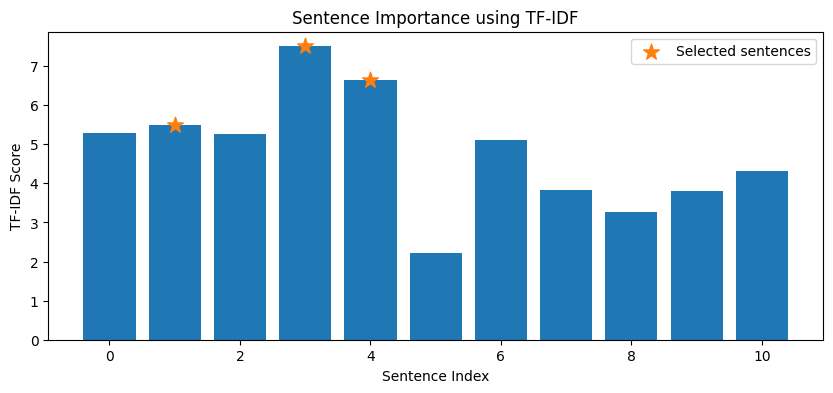

In [72]:
# ✅ gold_summary is TEXT, not indices. Use sentence indices (top_idx) to mark.
# If you don't have top_idx yet, compute it from your TF-IDF sentence scores.

summary_ratio = 0.3
n_sent = max(1, int(len(scores) * summary_ratio))

# pick top sentences by TF-IDF score
ranked_idx = np.argsort(scores)[::-1]       # descending
top_idx = np.sort(ranked_idx[:n_sent])      # keep original order

plt.figure(figsize=(10,4))
plt.bar(range(len(scores)), scores)

# ⭐ mark selected sentences
plt.scatter(top_idx, [scores[i] for i in top_idx],
            s=140, marker="*", label="Selected sentences")

plt.xlabel("Sentence Index")
plt.ylabel("TF-IDF Score")
plt.title("Sentence Importance using TF-IDF")
plt.legend()
plt.show()


4. Highligth Selected Sentences

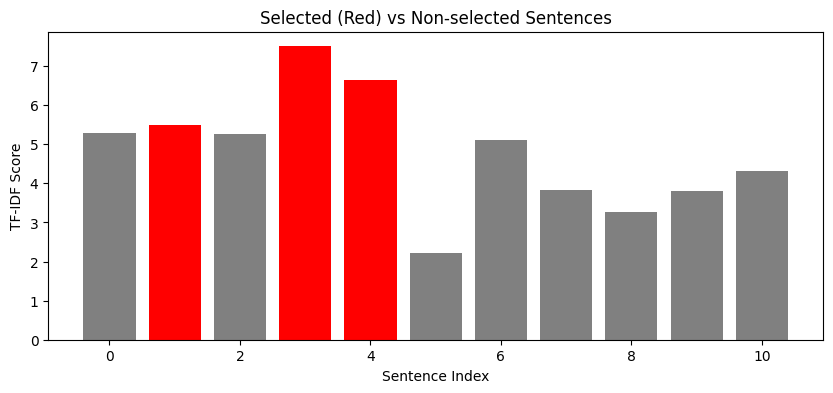

In [73]:
summary_indices = np.argsort(scores)[-max(1, int(len(scores)*0.3)):]
plt.figure(figsize=(10,4))
colors = ['red' if i in summary_indices else 'gray' for i in range(len(scores))]
plt.bar(range(len(scores)), scores, color=colors)
plt.xlabel("Sentence Index")
plt.ylabel("TF-IDF Score")
plt.title("Selected (Red) vs Non-selected Sentences")
plt.show()

5. ROUGE Score

In [74]:
rouge_scores = evaluate_rouge(gold_summary, pred_summary)
for metric, score in rouge_scores.items():
    print(f"{metric}: Precision={score.precision:.3f}, Recall={score.recall:.3f}, F1={score.fmeasure:.3f}")

rouge1: Precision=1.000, Recall=1.000, F1=1.000
rouge2: Precision=0.733, Recall=0.733, F1=0.733
rougeL: Precision=0.812, Recall=0.812, F1=0.812


## Model 2: TextRank Summarizer

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

1. Preprocess Sentence Text

In [76]:
def preprocess_text1(text):
    """
    Returns:
    - raw_sentences: original Khmer sentences
    - clean_sentences: preprocessed sentence strings for TF-IDF/embedding
    """
    raw_sentences = khmer_sentence_split(text)
    clean_sentences = []

    for s in raw_sentences:
        s_norm = tokenize_and_clean(s)
        tokens = word_tokenize(s_norm)
        tokens = [t for t in tokens if t not in KHMER_STOPWORDS]
        clean_sentences.append(" ".join(tokens))

    return raw_sentences, clean_sentences

2. TextRank Summarization

In [77]:
def textrank_summarize(text, summary_ratio=0.3):
    # Step 1: Preprocess
    raw_sentences, clean_sentences = preprocess_text1(text)  # <- UNPACK 2 variables only

    # Step 2: TF-IDF vectors for similarity
    vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.9)
    tfidf_matrix = vectorizer.fit_transform(clean_sentences)

    # Step 3: Cosine similarity matrix
    sim_matrix = cosine_similarity(tfidf_matrix)

    # Step 4: Build graph
    nx_graph = nx.from_numpy_array(sim_matrix)

    # Step 5: PageRank
    scores = nx.pagerank(nx_graph)

    # Step 6: Rank sentences
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(raw_sentences)), reverse=True)

    n_sentences = max(1, int(len(raw_sentences) * summary_ratio))
    top_sentences = [s for _, s in ranked_sentences[:n_sentences]]

    # Keep original order
    top_indices = sorted([raw_sentences.index(s) for s in top_sentences])
    summary = "។ ".join([raw_sentences[i] for i in top_indices]) + "។"

    return summary, scores, raw_sentences

3. ROUGE Evaluation

In [78]:
def evaluate_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=False)
    return scorer.score(reference, prediction)

4. First Article Example

In [79]:
text = data.loc[0, "text"]
gold_summary = data.loc[0, "summary"]

pred_summary, scores, sentences = textrank_summarize(text)

print("Predicted Summary:\n", pred_summary)
print("\nReference Summary:\n", gold_summary)

Predicted Summary:
 លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយថា រូបលោកមានភាពរីករាយ និង មោទនភាពបំផុតដែលបានដឹកនាំក្រុមមេឃខៀវយកបានតំណែងជើងឯកក្របខណ្ឌ Premier League សាជាថ្មីម្តងទៀត។ ជាការពិត Man City បានធានាជើងឯក Premier League បន្ទាប់ពីក្រុម Arsenal ដែលប្រដេញតំណែងជើងឯកយ៉ាងប្រកៀកប្រកិតរហូតមកនោះ បានប្រកួតចាញ់ក្រុម Nottingham Forest។ ថ្លែងឱ្យដឹងក្រោយចប់ការប្រកួតនិងការប្រារព្ធពិធីគ្រងជើងឯករួចមក លោក Pep Guardiola បានបញ្ចេញពីអារម្មណ៍រីករាយរបស់ខ្លួនថា “ តាំងពីដើមរដូវកាលមក Arsenal ត្រូវបានជឿថាជាក្រុមដែលមានភាគរយខ្ពស់ក្នុងការឈ្នះជើងឯក។

Reference Summary:
 Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២–២៣ បន្ទាប់ពី Arsenal ចាញ់ Nottingham Forest។ ក្រុមមេឃខៀវឈ្នះ១២ប្រកួតចុងក្រោយជាប់ៗ មាន៨៨ពិន្ទុ ខណៈ Arsenal មាន៨១។ ការប្រកួតឈ្នះ Chelsea ១–០ នឹងស៊ុតរបស់ Julian Alvarez បានធ្វើអោយក្រុមប្រារព្ធពាននៅ Etihad។ លោក Pep Guardiola បង្ហាញអារម្មណ៍រីករាយថា ការតស៊ូ និងការសហការគ្នាជារឿងសំខាន់។ ទោះមិនងាយស្រួល ក៏ក្រុមអាចធ្វើបាន។ នេះជាលើកទី៣ជាប់គ្នា និងពានទី៩ សម្រាប់ Man City និងជាពានលីគទី៥ របស់គាត់តាំងពីឆ្នាំ២០១

In [80]:
# Compute ROUGE
rouge_scores = evaluate_rouge(gold_summary, pred_summary)
for metric, score in rouge_scores.items():
    print(f"{metric}: Precision={score.precision:.3f}, Recall={score.recall:.3f}, F1={score.fmeasure:.3f}")

rouge1: Precision=0.750, Recall=0.750, F1=0.750
rouge2: Precision=0.600, Recall=0.600, F1=0.600
rougeL: Precision=0.562, Recall=0.562, F1=0.562


5. Plot Sentence Importance

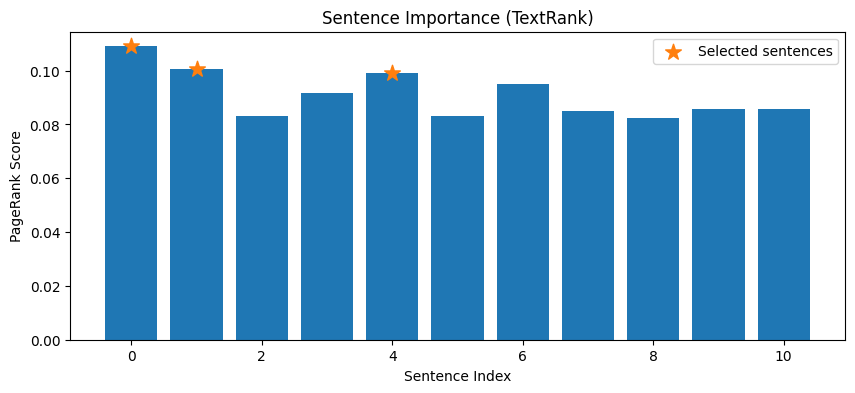

In [81]:
# ✅ gold_summary is text (string), not indices.
# You must mark using sentence INDICES (top_idx), not gold_summary.

# 1) get selected indices from TextRank scores (top K)
summary_ratio = 0.3
n_sentences = max(1, int(len(sentences) * summary_ratio))

ranked_idx = sorted(range(len(sentences)), key=lambda i: scores[i], reverse=True)
top_idx = sorted(ranked_idx[:n_sentences])   # keep original order

# 2) plot + mark selected sentences
plt.figure(figsize=(10, 4))
y = [scores[i] for i in range(len(sentences))]
plt.bar(range(len(sentences)), y)

plt.scatter(top_idx, [y[i] for i in top_idx],
            s=140, marker="*", label="Selected sentences")

plt.xlabel("Sentence Index")
plt.ylabel("PageRank Score")
plt.title("Sentence Importance (TextRank)")
plt.legend()
plt.show()


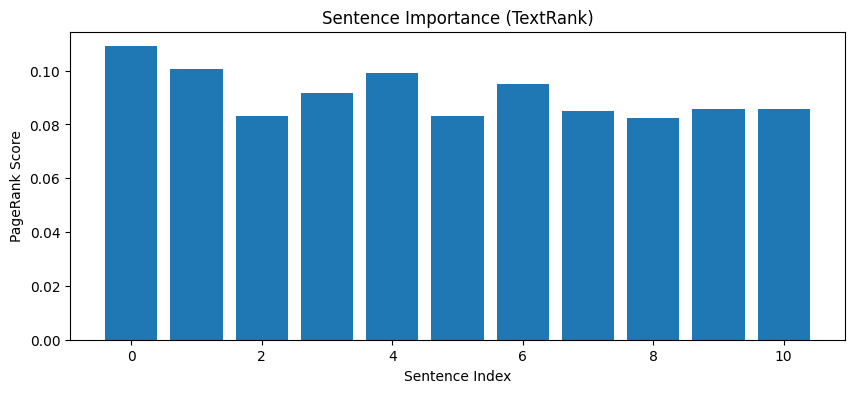

In [82]:
plt.figure(figsize=(10,4))
y = [scores[i] for i in range(len(sentences))]
plt.bar(range(len(sentences)), y)
plt.xlabel("Sentence Index")
plt.ylabel("PageRank Score")
plt.title("Sentence Importance (TextRank)")
plt.show()

6. TextRank Graph Visualization

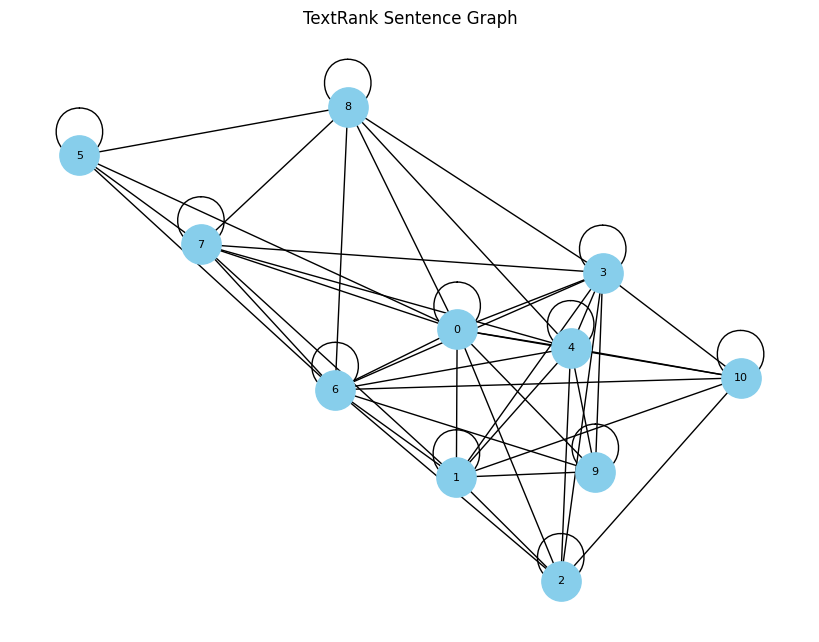

In [83]:
import networkx as nx

raw_sentences, clean_sentences = preprocess_text1(text)
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_matrix = vectorizer.fit_transform(clean_sentences)
sim_matrix = cosine_similarity(tfidf_matrix)

nx_graph = nx.from_numpy_array(sim_matrix)
pos = nx.spring_layout(nx_graph, seed=42)
plt.figure(figsize=(8,6))
nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=8)
plt.title("TextRank Sentence Graph")
plt.show()

## Model 3: Clutering-Based Algorithm

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

1. Clustering-Based Summarizer

In [85]:
def clustering_summarize(text, n_clusters=3):
    """
    Extractive summarization via clustering.
    Steps:
    1. Preprocess sentences
    2. TF-IDF vectorize
    3. KMeans clustering
    4. Pick central sentence from each cluster
    """
    # 1️⃣ Preprocess
    raw_sentences, clean_sentences = preprocess_text1(text)

    # If sentences < n_clusters, adjust
    n_clusters = min(n_clusters, len(raw_sentences))

    # 2️⃣ TF-IDF vectors
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(clean_sentences)

    # 3️⃣ KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_

    # 4️⃣ Pick most central sentence from each cluster
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    central_sentences = [raw_sentences[i] for i in closest]

    # Keep original order
    central_sentences_sorted = sorted(central_sentences, key=lambda s: raw_sentences.index(s))
    summary = "។ ".join(central_sentences_sorted) + "។"

    return summary, labels, raw_sentences

2. ROUGE Evaluation

In [86]:
def evaluate_rouge(reference, prediction):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=False)
    return scorer.score(reference, prediction)

3. First Article Example

In [87]:
text = data.loc[0, "text"]
gold_summary = data.loc[0, "summary"]

pred_summary, labels, sentences = clustering_summarize(text, n_clusters=3)

print("Predicted Summary:\n", pred_summary)
print("\nReference Summary:\n", gold_summary)

Predicted Summary:
 លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយថា រូបលោកមានភាពរីករាយ និង មោទនភាពបំផុតដែលបានដឹកនាំក្រុមមេឃខៀវយកបានតំណែងជើងឯកក្របខណ្ឌ Premier League សាជាថ្មីម្តងទៀត។ ជាការពិត Man City បានធានាជើងឯក Premier League បន្ទាប់ពីក្រុម Arsenal ដែលប្រដេញតំណែងជើងឯកយ៉ាងប្រកៀកប្រកិតរហូតមកនោះ បានប្រកួតចាញ់ក្រុម Nottingham Forest។ ប៉ុន្តែ ពួកយើង មិនបោះបង់ឱកាសនោះទេ។

Reference Summary:
 Man City ឈ្នះជើងឯក Premier League រដូវកាល ២០២២–២៣ បន្ទាប់ពី Arsenal ចាញ់ Nottingham Forest។ ក្រុមមេឃខៀវឈ្នះ១២ប្រកួតចុងក្រោយជាប់ៗ មាន៨៨ពិន្ទុ ខណៈ Arsenal មាន៨១។ ការប្រកួតឈ្នះ Chelsea ១–០ នឹងស៊ុតរបស់ Julian Alvarez បានធ្វើអោយក្រុមប្រារព្ធពាននៅ Etihad។ លោក Pep Guardiola បង្ហាញអារម្មណ៍រីករាយថា ការតស៊ូ និងការសហការគ្នាជារឿងសំខាន់។ ទោះមិនងាយស្រួល ក៏ក្រុមអាចធ្វើបាន។ នេះជាលើកទី៣ជាប់គ្នា និងពានទី៩ សម្រាប់ Man City និងជាពានលីគទី៥ របស់គាត់តាំងពីឆ្នាំ២០១៦។


In [88]:
# ROUGE
rouge_scores = evaluate_rouge(gold_summary, pred_summary)
for metric, score in rouge_scores.items():
    print(f"{metric}: Precision={score.precision:.3f}, Recall={score.recall:.3f}, F1={score.fmeasure:.3f}")

rouge1: Precision=0.846, Recall=0.688, F1=0.759
rouge2: Precision=0.750, Recall=0.600, F1=0.667
rougeL: Precision=0.538, Recall=0.438, F1=0.483


4. 2D Scatter Plot Using PCA

In [89]:
from sklearn.decomposition import PCA

def plot_clusters(text, n_clusters=3):
    # Preprocess
    raw_sentences, clean_sentences = preprocess_text1(text)

    # TF-IDF vectors
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(clean_sentences)

    # KMeans clustering
    kmeans = KMeans(n_clusters=min(n_clusters, len(raw_sentences)), random_state=42, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Central sentences
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)

    # Dimensionality reduction to 2D
    X_2d = PCA(n_components=2).fit_transform(X.toarray())

    # Plot
    plt.figure(figsize=(10,6))

    for cluster in range(n_clusters):
        idx = np.where(labels == cluster)
        plt.scatter(X_2d[idx,0], X_2d[idx,1], label=f"Cluster {cluster}", s=100)

    # Highlight central sentences
    plt.scatter(X_2d[closest,0], X_2d[closest,1], color='red', s=200, marker='*', label="Central Sentence")

    plt.title("Clustering-based Extractive Summarization (2D)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

    # Return summary sentences
    summary_sentences = [raw_sentences[i] for i in sorted(closest)]
    summary = "។ ".join(summary_sentences) + "។"
    return summary

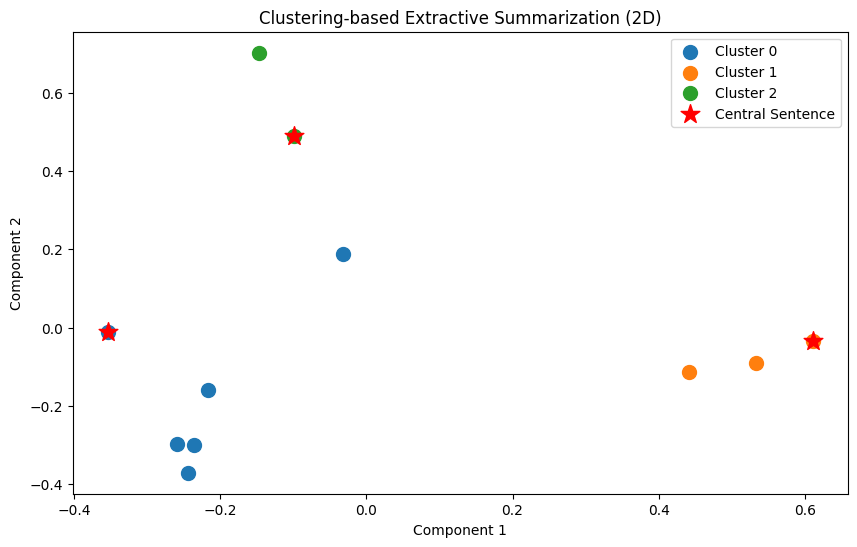

Summary:
 លោក Pep Guardiola គ្រូបង្វឹក Man City បាននិយាយថា រូបលោកមានភាពរីករាយ និង មោទនភាពបំផុតដែលបានដឹកនាំក្រុមមេឃខៀវយកបានតំណែងជើងឯកក្របខណ្ឌ Premier League សាជាថ្មីម្តងទៀត។ ជាការពិត Man City បានធានាជើងឯក Premier League បន្ទាប់ពីក្រុម Arsenal ដែលប្រដេញតំណែងជើងឯកយ៉ាងប្រកៀកប្រកិតរហូតមកនោះ បានប្រកួតចាញ់ក្រុម Nottingham Forest។ ប៉ុន្តែ ពួកយើង មិនបោះបង់ឱកាសនោះទេ។


In [90]:
text = data.loc[0, "text"]
summary = plot_clusters(text, n_clusters=3)
print("Summary:\n", summary)

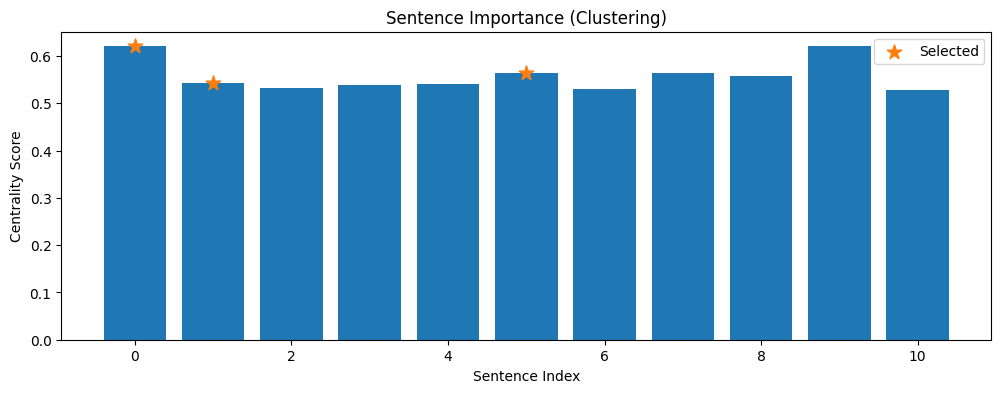

In [91]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clustering_scores(text, n_clusters=3):
    # preprocess_text1(text) must return: raw_sentences, clean_sentences
    raw_sentences, clean_sentences = preprocess_text1(text)

    n_clusters = min(n_clusters, len(raw_sentences))

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans

    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X = vectorizer.fit_transform(clean_sentences)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # distance to assigned centroid
    centers = kmeans.cluster_centers_
    X_dense = X.toarray()
    dists = np.linalg.norm(X_dense - centers[labels], axis=1)

    # centrality score (higher = more central)
    scores = 1 / (1 + dists)

    # chosen (most central) sentence per cluster
    chosen_idx = []
    for c in range(n_clusters):
        idx = np.where(labels == c)[0]
        chosen_idx.append(idx[np.argmin(dists[idx])])

    # plot
    plt.figure(figsize=(12, 4))
    x = np.arange(len(raw_sentences))
    plt.bar(x, scores)
    plt.scatter(chosen_idx, [scores[i] for i in chosen_idx], s=120, marker="*", label="Selected")
    plt.xlabel("Sentence Index")
    plt.ylabel("Centrality Score")
    plt.title("Sentence Importance (Clustering)")
    plt.legend()
    plt.show()

plot_clustering_scores(text, n_clusters=3)